In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
from pathlib import WindowsPath

from IPython import display

2.3.0


In [2]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
i16min = -2**15
i16max = 2**15-1
fsamp = 16000
use_microfrontend = True
#dataset = 'mini-speech'
dataset = 'project-speech'

In [4]:
if dataset == 'mini-speech':
  data_dir = pathlib.Path('data/mini_speech_commands')
  if not data_dir.exists():
    tf.keras.utils.get_file('mini_speech_commands.zip',
          origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
          extract=True, cache_dir='.', cache_subdir='data')
  commands = np.array(tf.io.gfile.listdir(str(data_dir)))
  commands = commands[commands != 'README.md']
elif dataset == 'project-speech':
  data_dir = 'data/project_speech_commands'
  commands = np.array(tf.io.gfile.listdir(str(data_dir)))
  commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['no' 'silence' 'tater' 'unknown']


In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir))))
print('Example file tensor:', filenames[0])

Number of total examples: 2480
Number of examples per label: 4
Example file tensor: tf.Tensor(b'data\\project_speech_commands\\unknown\\f84762e5_nohash_0.wav', shape=(), dtype=string)


In [6]:
if dataset == 'mini-speech':
  num_train_files = 6400 
  num_val_files = 800
  num_test_files = num_samples - num_train_files - num_val_files
  train_files = filenames[:num_train_files]
  val_files = filenames[num_train_files: num_train_files + num_val_files]
  test_files = filenames[-num_test_files:]
elif dataset == 'project-speech':
  num_train_files = 1800
  num_val_files = 300
  num_test_files = num_samples - num_train_files - num_val_files
  train_files = filenames[:num_train_files]
  val_files = filenames[num_train_files: num_train_files + num_val_files]
  test_files = filenames[-num_test_files:]
else:
  raise ValueError("dataset must be either project-speech or mini-speech")

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 1800
Validation set size 300
Test set size 380


In [7]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [8]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [10]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=40,
                                    window_size=40, window_step=20)
  return spectrogram


In [11]:
def wavds2specds(waveform_ds):
  spec_grams = np.zeros((0, 49, 40, 1))
  labels = []
  for wav, label in waveform_ds:
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams = np.concatenate((spec_grams, spectrogram))
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == commands)
    labels.append(new_label_id) # for numeric labels
    # labels.append(new_label) # for string labels
  return tf.data.Dataset.from_tensor_slices((spec_grams, labels))  

In [39]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
train_ds = wavds2specds(waveform_ds)

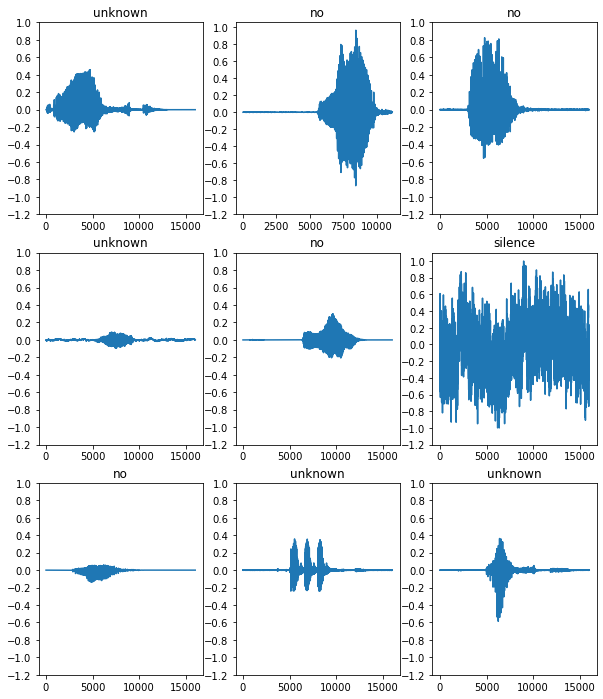

In [13]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [14]:
for waveform, label in waveform_ds.take(2):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (11146,)
Spectrogram shape: (49, 40)
Audio playback


E:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


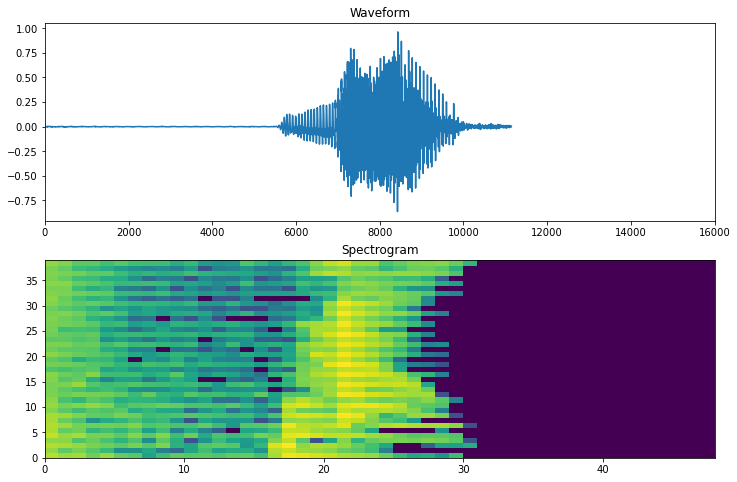

In [15]:
def plot_spectrogram(spectrogram, ax):
  # transpose so that the time is
  # represented in the x-axis (columns).
  freq_bins = spectrogram.shape[1]
  time_dur = spectrogram.shape[0]
  X = np.arange(time_dur)
  Y = range(freq_bins)
  ax.pcolormesh(X, Y, spectrogram.T)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

E:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


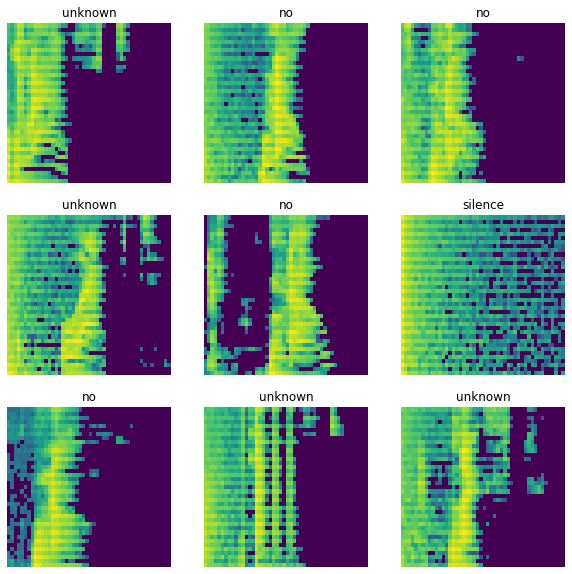

In [16]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [17]:
# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)
  output_ds = wavds2specds(waveform_ds)
  return output_ds

In [18]:
## training set is already builst
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [19]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [20]:
for spectrogram, _ in train_ds.take(1):
  spec1 = spectrogram
# take(1) takes 1 *batch*, so we have to select the first 
# spectrogram from it, hence the [0]
print(f"Spectrogram shape {spec1[0].shape}")
print(f"ranges from {np.min(spec1)} to {np.max(spec1)}")   # min/max across the whole batch

Spectrogram shape (49, 40, 1)
ranges from 0.0 to 710.0


In [21]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [22]:
for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first 
  # spectrogram from it, hence the [0]
  input_shape = spectrogram[0].shape  
print('Input shape:', input_shape)
num_labels = len(commands)
print(num_labels)

Input shape: (49, 40, 1)
4


In [23]:
print('Input shape:', input_shape)

#model_id = "simple"
model_id = "complex2"

if model_id == "complex" :
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        #layers.Conv2D(64, 3, activation='relu'),
        #layers.MaxPooling2D(pool_size=(4,4)),
        #layers.BatchNormalization(),
        layers.Dropout(0.15),
        layers.Flatten(),
        #layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
        layers.Softmax(),
    ], name="complex_cnn")
elif model_id == "complex2" :
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(4, 4, activation='relu'),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        layers.Conv2D(8, 4, activation='relu'),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
        layers.Softmax(),
    ], name="complex2_cnn")
else :
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.DepthwiseConv2D(16, 3, activation='relu'), 
        layers.Dense(num_labels),
        layers.Softmax(),
        layers.Flatten(),
    ], name="simple_cnn")




model.summary()

Input shape: (49, 40, 1)
Model: "complex2_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 37, 4)         68        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 18, 4)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 18, 4)         16        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 15, 8)         520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 7, 8)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 7, 8)          32        
_________________________________________________________________
flatten (Flatten)            

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [25]:
EPOCHS = 25
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/25
29/29 [==============================] - 1s 19ms/step - loss: 1.2845 - accuracy: 0.4183 - val_loss: 1.5198 - val_accuracy: 0.1967
Epoch 2/25
29/29 [==============================] - 0s 15ms/step - loss: 1.0863 - accuracy: 0.6622 - val_loss: 1.3789 - val_accuracy: 0.3067
Epoch 3/25
29/29 [==============================] - 0s 16ms/step - loss: 1.0127 - accuracy: 0.7428 - val_loss: 1.2125 - val_accuracy: 0.4900
Epoch 4/25
29/29 [==============================] - 0s 15ms/step - loss: 0.9711 - accuracy: 0.7767 - val_loss: 1.0591 - val_accuracy: 0.7167
Epoch 5/25
29/29 [==============================] - 0s 15ms/step - loss: 0.9355 - accuracy: 0.8133 - val_loss: 0.9787 - val_accuracy: 0.7967
Epoch 6/25
29/29 [==============================] - 0s 16ms/step - loss: 0.9114 - accuracy: 0.8400 - val_loss: 0.9445 - val_accuracy: 0.8033
Epoch 7/25
29/29 [==============================] - 0s 16ms/step - loss: 0.8925 - accuracy: 0.8556 - val_loss: 0.9178 - val_accuracy: 0.8467
Epoch 8/25
29

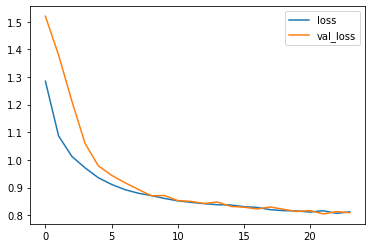

In [26]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [27]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [28]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 94%


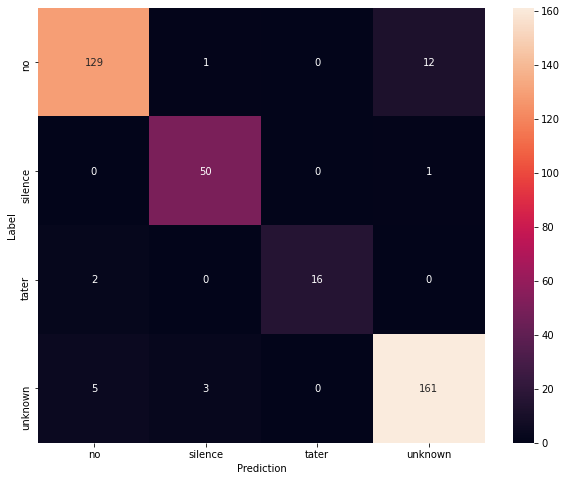

In [29]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [30]:
label_counts = {}
for spectrogram, label_id in train_ds.unbatch():
    label_str = commands[label_id.numpy()]
    if commands[label_id.numpy()] in label_counts:
        label_counts[label_str] += 1
    else:
        label_counts[label_str] = 1
print(label_counts)

{'unknown': 731, 'no': 729, 'silence': 255, 'tater': 85}


# this doesnt work for some reason, so im not gonna run it

sample_file = data_dir/'stop/0b40aa8e_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for ')
  plt.show()

# Quantize and Convert to TFLite

In [31]:
model.save('keras_model')

#converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file('keras_model')

converter.optimizations = [tf.lite.Optimize.DEFAULT]

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: keras_model\assets
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [32]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

In [33]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter.inference_output_type = tf.int8  # or tf.uint8

In [34]:
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Dylan\AppData\Local\Temp\tmp1r328u44\assets
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from C:\Users\Dylan\AppData\Local\Temp\tmp1r328u44\variables\variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1
INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 49, 40, 1), type: DT_FLOAT
INFO:tensorflow:output tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: softmax
INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 4), type: DT_FLOAT
INFO:tensorflow:Resto

In [35]:
fname = 'kws_model6.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

Wrote 8560 / 8560 bytes to tflite file


In [36]:
# Install xxd if it is not available
#!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
#!xxd -i 'kws_model1.tflite' > 'kws_model1.cc'
# Update variable names
#REPLACE_TEXT = 'kws_model.tflite'.replace('/', '_').replace('.', '_')
#!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {'kws_model.cc'}